In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import scipy as sp
import h5py
from scipy.interpolate import interp1d
from scipy.linalg import sqrtm, solve_sylvester, solve_lyapunov
import matplotlib.pyplot as plt
import sys
import pseudo
import os
import glob
import miscUtil
import ops
%matplotlib inline

os.environ['DATA'] = os.environ['DATA186']
physDataDir = os.environ['DATA'] + 'phys/'
specDataDir = os.environ['DATA'] + 'spec/'
covDataDir = os.environ['DATA'] + 'cov/'
libDir = os.environ['LINLIB']
figureFolder = 'figures/'

# Compare terms due to eddy viscosity to actual NL terms
## For a single snapshot at t=150000

### Computing the convection terms in physical space

In [6]:
# Domain and field parameters
a0 = 0.25; b0 = 2./3.
N = 192; Nx = 512; Nz = 320

# Compute derivatives on a reduced grid for performance
nx = 4; nz = 4
Nx1 = Nx//nx; Nz1 = Nz//nz

y,DM = pseudo.chebdif(N,1)
D = DM.reshape((N,N))

loadPath = physDataDir
# Use tArr instead of a scalar 't' so it's easy to extend to time-averages later
tArr = np.arange(150000, 150050, 500)
modeArr = np.zeros(3*N, dtype=np.complex)

# Collect each convection term individually
xConvU = np.zeros((Nx1,Nz1,N))
xConvV = np.zeros((Nx1,Nz1,N))
xConvW = np.zeros((Nx1,Nz1,N))
yConvU = np.zeros((Nx1,Nz1,N))
yConvV = np.zeros((Nx1,Nz1,N))
yConvW = np.zeros((Nx1,Nz1,N))
zConvU = np.zeros((Nx1,Nz1,N))
zConvV = np.zeros((Nx1,Nz1,N))
zConvW = np.zeros((Nx1,Nz1,N))

# Truncation of Fourier modes in x
xRange = np.r_[0:Nx1//2+1, Nx-(Nx1//2)+1:Nx]

for t in tArr:
    # Remember that DNS has y as spanwise
    ufName = loadPath+ 'u_it%s.dat'%t
    vfName = loadPath+ 'w_it%s.dat'%t
    wfName = loadPath+ 'v_it%s.dat'%t
    
    with open(ufName,'rb') as inFile:
        uArrRaw = np.fromfile(inFile, dtype=np.float, count=-1)
    with open(vfName,'rb') as inFile:
        vArrRaw = np.fromfile(inFile, dtype=np.float, count=-1)
    with open(wfName,'rb') as inFile:
        wArrRaw = np.fromfile(inFile, dtype=np.float, count=-1)
    
    uArr = uArrRaw.reshape((Nx,Nz,N))
    vArr = vArrRaw.reshape((Nx,Nz,N))
    wArr = wArrRaw.reshape((Nx,Nz,N))
    print("Loaded raw fields at t=",t)
    
    
    print("Computing FFTd fields...")
    # FFT to calculate derivatives
    # I'm not dividing by Nx*Nz because I'll shortly do an ifft anyway
    ufft = np.fft.rfftn(uArr, axes=(0,1))[xRange,:Nz1//2+1]/Nx/Nz
    vfft = np.fft.rfftn(vArr, axes=(0,1))[xRange,:Nz1//2+1]/Nx/Nz
    wfft = np.fft.rfftn(wArr, axes=(0,1))[xRange,:Nz1//2+1]/Nx/Nz
    
    #aArr = a0 * np.concatenate(( np.arange(0,Nx1//2+1), np.arange(-Nx1//2+1,0)  ))
    aArr = a0 * np.asarray(xRange)
    bArr = b0* np.arange(0,Nz1//2+1)
    
    
    
    print("Interpolating to cheb nodes in Fourier domain...")
    # Interpolate from the cell-centred DNS data to Cheb nodes
    ufft = miscUtil.interpDNS(ufft.reshape((ufft.size//N,N)), nCheb=N)[0]
    vfft = miscUtil.interpDNS(vfft.reshape((vfft.size//N,N)), nCheb=N)[0]
    wfft = miscUtil.interpDNS(wfft.reshape((wfft.size//N,N)), nCheb=N)[0]
    ufft = ufft.reshape((Nx1, Nz1//2+1, N))
    vfft = vfft.reshape(ufft.shape)
    wfft = wfft.reshape(ufft.shape)
    
    print("Norms of (0,0) modes of u,v,w are", 
          pseudo.chebnorm(ufft[0,0],N), pseudo.chebnorm(vfft[0,0],N), pseudo.chebnorm(wfft[0,0],N))
    
    print("Setting zeroth mode to 0...")
    ufft[0,0] = 0.
    vfft[0,0] = 0.
    wfft[0,0] = 0.
    
    
    print("Computing x and z derivatives in Fourier domain...")
    # Streamwise derivatives
    # First, in spectral domain
    ufftx = 1.j * aArr.reshape((aArr.size,1,1)) * ufft
    vfftx = 1.j * aArr.reshape((aArr.size,1,1)) * vfft
    wfftx = 1.j * aArr.reshape((aArr.size,1,1)) * wfft
    
    # Spanwise derivatives
    # First, in spectral domain
    ufftz = 1.j * bArr.reshape((1,bArr.size,1)) * ufft
    vfftz = 1.j * bArr.reshape((1,bArr.size,1)) * vfft
    wfftz = 1.j * bArr.reshape((1,bArr.size,1)) * wfft
    
    print("Computing fields and their derivatives in physical domain...")
    u = np.fft.irfftn(ufft, axes=(0,1))*Nx1*Nz1
    v = np.fft.irfftn(vfft, axes=(0,1))*Nx1*Nz1
    w = np.fft.irfftn(wfft, axes=(0,1))*Nx1*Nz1
    # Streamwise derivative
    ux = np.fft.irfftn(ufftx, axes=(0,1))*Nx1*Nz1
    vx = np.fft.irfftn(vfftx, axes=(0,1))*Nx1*Nz1
    wx = np.fft.irfftn(wfftx, axes=(0,1))*Nx1*Nz1
    # Spanwise derivative
    uz = np.fft.irfftn(ufftz, axes=(0,1))*Nx1*Nz1
    vz = np.fft.irfftn(vfftz, axes=(0,1))*Nx1*Nz1
    wz = np.fft.irfftn(wfftz, axes=(0,1))*Nx1*Nz1
    # wall-normal derivatives
    uy = u @ D.T 
    vy = v @ D.T
    wy = w @ D.T
    
    
    print("Adding NL terms due to fluctuations to cummulative...")
    # Convection terms in streamwise momentum
    xConvU[:] += u * ux
    xConvV[:] += v * uy
    xConvW[:] += w * uz
    
    # Convection terms in wall-normal momentum
    yConvU[:] += u * vx
    yConvV[:] += v * vy
    yConvW[:] += w * vz
    
    # Convection terms in spanwise momentum
    zConvU[:] += u * wx
    zConvV[:] += v * wy
    zConvW[:] += w * wz
    print()
    sys.stdout.flush()
    
    
xConvU = xConvU/tArr.size
xConvV = xConvV/tArr.size
xConvW = xConvW/tArr.size
yConvU = yConvU/tArr.size
yConvV = yConvV/tArr.size
yConvW = yConvW/tArr.size
zConvU = zConvU/tArr.size
zConvV = zConvV/tArr.size
zConvW = zConvW/tArr.size
    
    
    

Loaded raw fields at t= 150000
Computing FFTd fields...
Interpolating to cheb nodes in Fourier domain...
Norms of (0,0) modes of u,v,w are 16.1199688931 1.14587628762e-16 0.0166828191103
Setting zeroth mode to 0...
Computing x and z derivatives in Fourier domain...
Computing fields and their derivatives in physical domain...
Adding NL terms due to fluctuations to cummulative...



In [10]:
convPhys = np.zeros((9,Nx1,Nz1,N))
convPhys[0] = xConvU
convPhys[1] = xConvV
convPhys[2] = xConvW
convPhys[3] = yConvU
convPhys[4] = yConvV
convPhys[5] = yConvW
convPhys[6] = zConvU
convPhys[7] = zConvV
convPhys[8] = zConvW
meanFun = lambda someArr: np.mean(np.mean(someArr,axis=1),axis=0)
#sp.io.savemat('convNL.mat', {'convPhys':convPhys})

### Let's plot the averages of each of the convection terms

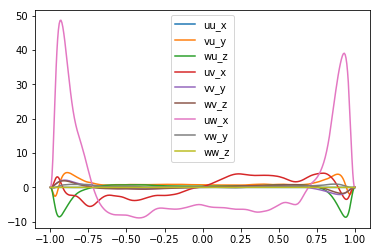

In [11]:
for k in range(9):
    plt.plot(y, meanFun(convPhys[k]))
plt.legend(['uu_x', 'vu_y', 'wu_z', 'uv_x', 'vv_y', 'wv_z', 'uw_x', 'vw_y', 'ww_z', ])
plt.show()



Strange.... I wouldn't have thought the $u\partial_x w$ term would be so large. I've already gotten rid of $u_{00}$.. Right?

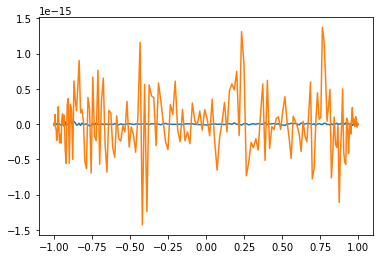

In [16]:
plt.plot(y, meanFun(u))
plt.plot(y, meanFun(wx))
plt.show()

$u$ and $\partial_x w$ are both of zero-mean, as they should be. I wonder what it is that makes the term so large then. 

Before we get ahead of ourselves, let's look at the terms in x-momentum. Particularly, the decomposition $\partial_y(uv) = uv_y + vu_y$

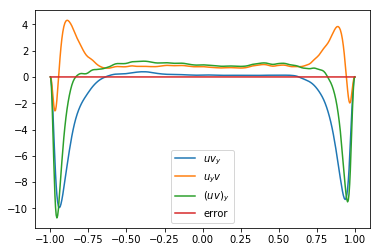

In [19]:
plt.plot(y, meanFun(u*vy))
plt.plot(y, meanFun(uy*v))
plt.plot(y, D@meanFun(u*v))
plt.plot(y, meanFun(uy*v + u*vy) - D@meanFun(u*v))
plt.legend(['$uv_y$', '$u_yv$', '$(uv)_y$','error'])
plt.show()

Clearly, $uv_y$ is not zero. 

My earlier wondering that $(uv)_y$ may be equal to $vu_y$ because $uv_y=0$ is wrong. Back to reading up on eddy viscosity then. 

Stupid me! 

It's not that $uv_y$ is zero. What's zero is the sum $uu_x + uv_y + uw_z$. The convection terms can be rewritten as follows

\begin{align*}
 u\partial_x u^j + v\partial_y u^j + w \partial_z u^j 
     &= \partial_x(uu^j) + \partial_y(vu^j) + \partial_z(wu^j) 
         -\bigg\{ u^j \big(\partial_x u + \partial_y v + \partial_z w\big) \bigg\}\\
         &= \partial_x(uu^j) + \partial_y(vu^j) + \partial_z(wu^j) 
\end{align*}

In the equation for the $(0,0)$ mode, the streamwise and spanwise derivatives drop out, so that the only convection term that remains is $\partial_y(uv)$. 

Let's have a look at this for my flowfield snapshot. 

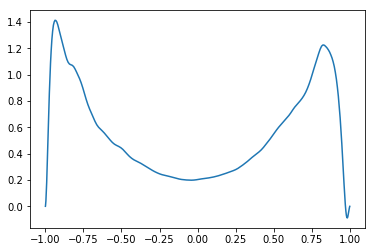

In [21]:
conv1 = meanFun( u*ux + v*uy + w*uz)
conv2 = D @ meanFun(u*v)
plt.plot(y, conv1 - conv2)
plt.show()

That's funny now. Where did I mess up? 

Let's plot the other terms, the terms that should sum to zero. 

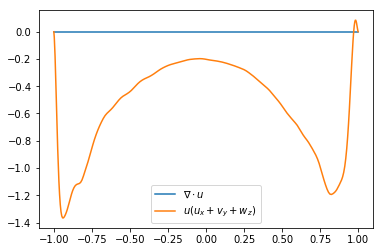

In [27]:
div = meanFun(ux+vy+wz)
conv3 = meanFun( u*(ux+vy+wz))
plt.plot(y,div)
plt.plot(y,conv3)
plt.legend(['$\\nabla \cdot u$', '$u(u_x+v_y+w_z)$'])
plt.show()

Now that's quite messed up. It means the divergence isn't zero everywhere, but it's only zero on average. Let's have another look at the divergence to ensure this is the case. 

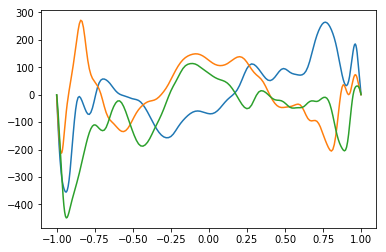

In [29]:
divField = ux + vy + wz
plt.plot(y, divField[0,0])
plt.plot(y, divField[0,50])
plt.plot(y, divField[100,0])
plt.show()



Now that's seriously messed up. 

Of course, all of this mess could just be because of the wall-normal differentiation. The divergence is just too big here. Let's look at the contribution fromt he different terms here.

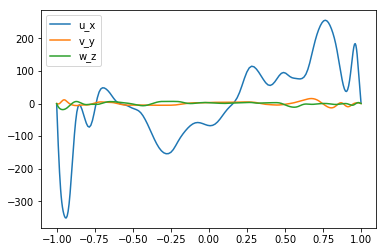

In [31]:
plt.plot(y, ux[0,0])
plt.plot(y, vy[0,50])
plt.plot(y, wz[100,0])
plt.legend(['u_x', 'v_y', 'w_z'])
plt.show()

Ah, that's weird. So it's not related to the differentiation at all. For some reason, the x-derivative is way too large. 

You know what, let's forget about all of this. I don't need to do it this way if all I'm interested in is comparing eddy viscosities for the (0,0) mode. Let's do this bit first. 

# Simpler verification of eddy viscosity

What we do now is compare $\bigg< uv \bigg>$ to $\nu_e \frac{dU}{dy}$

Using parameters Re=186, alfa=46.5, kapa=0.61, N=192


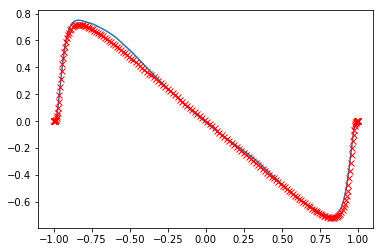

In [37]:
ufName = loadPath+ 'u_it%s.dat'%t
vfName = loadPath+ 'w_it%s.dat'%t

with open(ufName,'rb') as inFile:
    uArrRaw = np.fromfile(inFile, dtype=np.float, count=-1)
with open(vfName,'rb') as inFile:
    vArrRaw = np.fromfile(inFile, dtype=np.float, count=-1)

uArr = uArrRaw.reshape((Nx,Nz,N))
vArr = vArrRaw.reshape((Nx,Nz,N))
uArr = uArr[:,:,::-1]
vArr = vArr[:,:,::-1]
# Because the binaries are stored for increasing y

meanFun = lambda someArr: np.mean(np.mean(someArr,axis=1),axis=0)

RSSfluc = -meanFun(uArr*vArr)

Re = 186.
meanDict = ops.turbMeanChannel(N=192,Re=Re)
nuEddy = meanDict['nu'] - 1.
dU = meanDict['dU']
y = meanDict['y']
RSSeddy = nuEddy/Re * dU



plt.plot(y, RSSfluc)
plt.plot(y, RSSeddy,'rx')
plt.show()


  
    
    
    

That's close enough. I wouldn't expect them to match, because I haven't used a temporal average when computing RSSfluc. 

# Simple comparison of eddy viscosity for non-zero modes

To avoid the mess created by all the interpolation and FTs, let's just compare $(uv)_{l,m}$ with $\nu_e \partial_y u_{l,m}$ and see what happens.

In [55]:
a0 = 0.25; b0 = 2./3.
Re = 186.
Nx = 512; Ny = 384; N = 192

meanFun = lambda someArr: np.mean(np.mean(someArr, axis=1),axis=0)

ufName = loadPath+ 'u_it%s.dat'%t
vfName = loadPath+ 'w_it%s.dat'%t

with open(ufName,'rb') as inFile:
    uArrRaw = np.fromfile(inFile, dtype=np.float, count=-1)
with open(vfName,'rb') as inFile:
    vArrRaw = np.fromfile(inFile, dtype=np.float, count=-1)

uArr = uArrRaw.reshape((Nx,Nz,N))
vArr = vArrRaw.reshape((Nx,Nz,N))
uArr = uArr[:,:,::-1]
vArr = vArr[:,:,::-1]

# Convert into fluctuations
uArr = uArr - meanFun(uArr).reshape((1,1,N))
vArr = vArr - meanFun(vArr).reshape((1,1,N))

# Because the binaries are stored for increasing y

uvArr = uArr * vArr

uSpec  = np.fft.rfftn( uArr , axes=(0,1))/Nx/Nz
uvSpec = np.fft.rfftn( uvArr, axes=(0,1))/Nx/Nz





/home/svadarevu/gitwork/linear/library/miscUtil.py:195: UserWarning: arr supplied to cenDiff must be on y from 1 to -1, NOT -1 to 1
  warn("arr supplied to cenDiff must be on y from 1 to -1, NOT -1 to 1")


Using parameters Re=186, alfa=46.5, kapa=0.61, N=192


/home/svadarevu/linenv/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


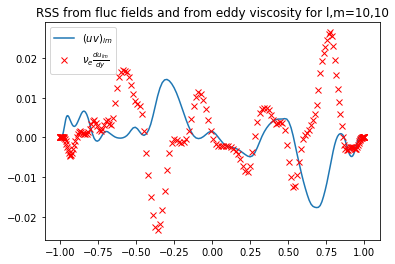

In [57]:
l = 10; m=10
u_lm  =  uSpec[l,m]
uv_lm = uvSpec[l,m]
# Remember that these are all defined on cell centers of DNS nodes
yCC = miscUtil.nodesCellCenters(nCells=192)

# I need a derivative of u_lm
# Let's go with a simple central difference for the derivative
dy_u_lm = miscUtil.cenDiff(u_lm, nCells= u_lm.size)

meanDict = ops.turbMeanChannel(N=192,Re=Re)
nuEddy = meanDict['nu'] - 1.
if l==0 and m==0:
    dy_u_lm += meanDict['dU']

RSSfluc = -uv_lm
RSSeddy = nuEddy/Re * dy_u_lm


plt.plot(y, RSSfluc)
plt.plot(y, RSSeddy,'rx')
plt.title("RSS from fluc fields and from eddy viscosity for l,m=%d,%d"%(l,m))
plt.legend(['$(uv)_{lm}$','$\\nu_e \\frac{du_{lm}}{dy}$'])
plt.show()

# ''Correlation'' between RSS terms 

For 
    RSSfluc := $-uv_{lm}$
and
    RSSeddy := $\nu_e \frac{du_{lm}}{dy}$, 

I'll define a correlation as the dot product of the two divided by the product of their norms. 

For the dot product, I'll just use pseudo.chebdot. This isn't the right one to use, but it's close enough to get the job done. And since I'm not changing grids, the grid dependency doesn't matter and I can think of it as an abstract measure

In [58]:
a0 = 0.25; b0 = 2./3.
Re = 186.
Nx = 512; Nz = 320; N = 192
loadPath = physDataDir

meanFun = lambda someArr: np.mean(np.mean(someArr, axis=1),axis=0)

ufName = loadPath+ 'u_it%s.dat'%t
vfName = loadPath+ 'w_it%s.dat'%t

with open(ufName,'rb') as inFile:
    uArrRaw = np.fromfile(inFile, dtype=np.float, count=-1)
with open(vfName,'rb') as inFile:
    vArrRaw = np.fromfile(inFile, dtype=np.float, count=-1)

uArr = uArrRaw.reshape((Nx,Nz,N))
vArr = vArrRaw.reshape((Nx,Nz,N))
uArr = uArr[:,:,::-1]
vArr = vArr[:,:,::-1]

# Convert into fluctuations
uArr = uArr - meanFun(uArr).reshape((1,1,N))
vArr = vArr - meanFun(vArr).reshape((1,1,N))

# Because the binaries are stored for increasing y

uvArr = uArr * vArr

uSpec  = np.fft.rfftn( uArr , axes=(0,1))/Nx/Nz
uvSpec = np.fft.rfftn( uvArr, axes=(0,1))/Nx/Nz





In [77]:
corrArr = np.zeros((uSpec.shape[0]//2+1, uSpec.shape[1]),dtype=np.complex)
meanDict = ops.turbMeanChannel(N=192,Re=Re)
nuEddy = meanDict['nu'] - 1.

for l in range(corrArr.shape[0]):
    for m in range(corrArr.shape[1]):
        u_lm  =  uSpec[l,m]
        uv_lm = uvSpec[l,m]

        # I need a derivative of u_lm
        # Let's go with a simple central difference for the derivative
        dy_u_lm = miscUtil.cenDiff(u_lm, nCells= u_lm.size)

        if l==0 and m==0:
            dy_u_lm += meanDict['dU']

        RSSfluc = -uv_lm
        RSSeddy = nuEddy/Re * dy_u_lm

        
        corrArr[l,m] = pseudo.chebdot(RSSfluc, RSSeddy,N)/ \
                    (pseudo.chebnorm(RSSfluc,N)*pseudo.chebnorm(RSSeddy,N))
        
        

Using parameters Re=186, alfa=46.5, kapa=0.61, N=192


/home/svadarevu/gitwork/linear/library/miscUtil.py:195: UserWarning: arr supplied to cenDiff must be on y from 1 to -1, NOT -1 to 1
  warn("arr supplied to cenDiff must be on y from 1 to -1, NOT -1 to 1")


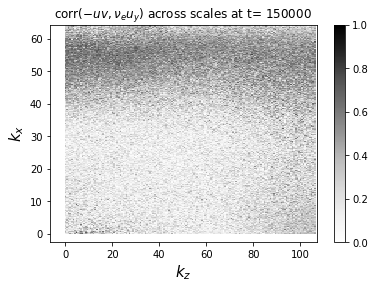

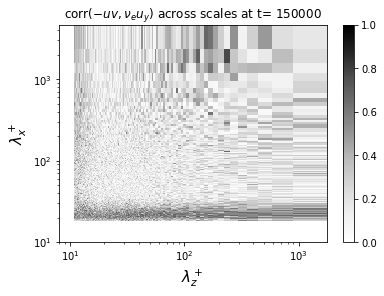

In [110]:
aArr = a0 * np.arange(corrArr.shape[0])
bArr = b0 * np.arange(corrArr.shape[1])
t=150000
plt.pcolor(bArr, aArr, np.abs(corrArr), cmap='Greys',vmin=0.,vmax=1.)
#plt.clim([0.,1.])
#plt.grid(True)
ax = plt.gca() 
plt.xlim([-10*b0,b0*corrArr.shape[1]])
plt.ylim([-10*a0,a0*corrArr.shape[0]])
plt.colorbar()
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("corr($-uv, \\nu_e u_y$) at t=%7.0d"%t)
plt.show()

corrArrNew = corrArr[1:,1:]
lxArr = 2.*np.pi/aArr[1:]
lzArr = 2.*np.pi/bArr[1:]
plt.pcolor(Re*lzArr, Re*lxArr, np.abs(corrArrNew), cmap='Greys',vmin=0.,vmax=1.)
#plt.clim([0.,1.])
#plt.grid(True)
plt.xlabel("$\\lambda^+_z$",fontsize=15)
plt.ylabel("$\\lambda^+_x$",fontsize=15)
plt.title("corr($-uv, \\nu_e u_y$) at t=%7.0d"%t)
ax = plt.gca() 
Lx = 2.*np.pi/a0; Lz = 2.*np.pi/b0
plt.xlim([8, Re*Lz])
plt.ylim([10, Re*Lx])
#ax.set_ylim(ax.get_ylim()[::-1]) 
plt.xscale("log"); plt.yscale("log")
plt.colorbar()
plt.show()



Clearly, the eddy viscosity computed from the mean velocity is pretty useless at most scales. 

# A complete map of eddy viscosity for $(u^j v)$

In [10]:
a0 = 0.25; b0 = 2./3.
Re = 186.
Nx = 512; Nz = 320; N = 192
aArr = a0 * np.arange(Nx//2+1)
bArr = b0 * np.arange(Nz//2+1)
loadPath = physDataDir

meanFun = lambda someArr: np.mean(np.mean(someArr, axis=1),axis=0)
meanDict = ops.turbMeanChannel(N=192,Re=Re)
nuEddy = meanDict['nu'] - 1.
yCC = miscUtil.nodesCellCenters(nCells=192)

def getSpecFields(t):
    ufName = loadPath+ 'v_it%s.dat'%t
    vfName = loadPath+ 'w_it%s.dat'%t
    

    with open(ufName,'rb') as inFile:
        uArrRaw = np.fromfile(inFile, dtype=np.float, count=-1)
    with open(vfName,'rb') as inFile:
        vArrRaw = np.fromfile(inFile, dtype=np.float, count=-1)
    
    uArr = uArrRaw.reshape((Nx,Nz,N))
    vArr = vArrRaw.reshape((Nx,Nz,N))
    uArr = uArr[:,:,::-1]
    vArr = vArr[:,:,::-1]
    
    
    # Convert into fluctuations
    uArr = uArr - meanFun(uArr).reshape((1,1,N))
    vArr = vArr - meanFun(vArr).reshape((1,1,N))
    
    # Because the binaries are stored for increasing y

    uvArr = uArr * vArr

    uSpec  = np.fft.rfftn( uArr , axes=(0,1))/Nx/Nz
    uvSpec = np.fft.rfftn( uvArr, axes=(0,1))/Nx/Nz
    
    return uSpec, uvSpec


def getCorrArr(t):
    uSpec, uvSpec = getSpecFields(t)
    corrArr = np.zeros((uSpec.shape[0]//2+1, uSpec.shape[1]),dtype=np.complex)
    for l in range(corrArr.shape[0]):
        for m in range(corrArr.shape[1]):
            u_lm  =  uSpec[l,m]
            uv_lm = uvSpec[l,m]

            # I need a derivative of u_lm
            # Let's go with a simple central difference for the derivative
            dy_u_lm = miscUtil.cenDiff(u_lm, nCells= u_lm.size)

            #if l==0 and m==0:
                #dy_u_lm += meanDict['dU']

            RSSfluc = -uv_lm
            RSSeddy = nuEddy/Re * dy_u_lm


            corrArr[l,m] = pseudo.chebdot(RSSfluc, RSSeddy,N)/ \
                        (pseudo.chebnorm(RSSfluc,N)*pseudo.chebnorm(RSSeddy,N))

    return corrArr


def plotCorrArr(t,fPrefix='corrEddy',savePath='./'):
    corrArr = getCorrArr(t)
    
    fName = savePath+fPrefix+'_wv_wnum_t%d.eps'%t
    plt.pcolor(bArr, aArr, np.abs(corrArr), cmap='Greys',vmin=0.,vmax=1.)
    #plt.clim([0.,1.])
    #plt.grid(True)
    ax = plt.gca() 
    plt.xlim([-10*b0,b0*corrArr.shape[1]])
    plt.ylim([-10*a0,a0*corrArr.shape[0]])
    plt.colorbar()
    plt.xlabel("$k_z$",fontsize=15)
    plt.ylabel("$k_x$",fontsize=15)
    plt.title("corr($-wv, \\nu_e w_y$) at t=%7.0d"%t)
    plt.savefig(fName,format='eps')
    plt.show()

    fName = savePath+fPrefix+'_wv_wlen_t%d.eps'%t
    corrArrNew = corrArr[1:,1:]
    lxArr = 2.*np.pi/aArr[1:]
    lzArr = 2.*np.pi/bArr[1:]
    plt.pcolor(Re*lzArr, Re*lxArr, np.abs(corrArrNew), cmap='Greys',vmin=0.,vmax=1.)
    #plt.clim([0.,1.])
    #plt.grid(True)
    plt.xlabel("$\\lambda^+_z$",fontsize=15)
    plt.ylabel("$\\lambda^+_x$",fontsize=15)
    plt.title("corr($-wv, \\nu_e w_y$) at t=%7.0d"%t)
    ax = plt.gca() 
    Lx = 2.*np.pi/a0; Lz = 2.*np.pi/b0
    plt.xlim([8, Re*Lz])
    plt.ylim([10, Re*Lx])
    #ax.set_ylim(ax.get_ylim()[::-1]) 
    plt.xscale("log"); plt.yscale("log")
    plt.colorbar()
    plt.savefig(fName,format='eps')
    plt.show()
    return




Using parameters Re=186, alfa=46.5, kapa=0.61, N=192


/home/svadarevu/gitwork/linear/library/miscUtil.py:195: UserWarning: arr supplied to cenDiff must be on y from 1 to -1, NOT -1 to 1
  warn("arr supplied to cenDiff must be on y from 1 to -1, NOT -1 to 1")


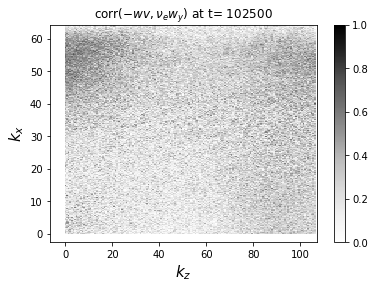

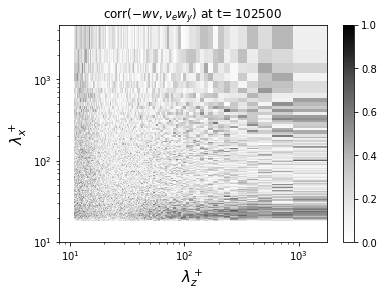

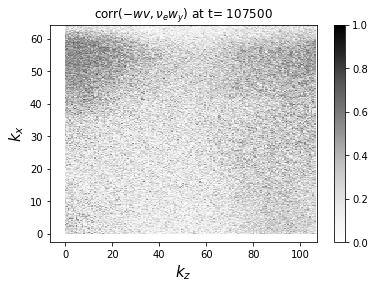

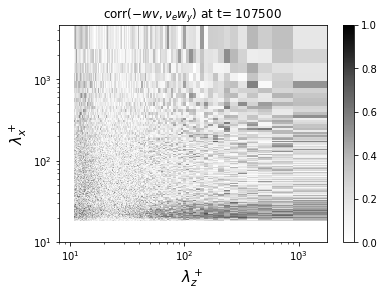

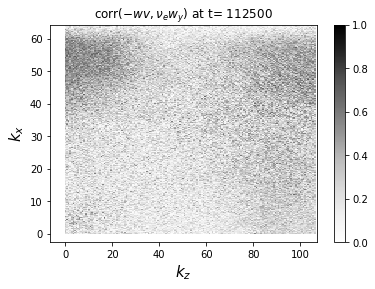

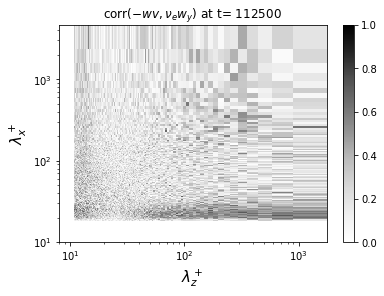

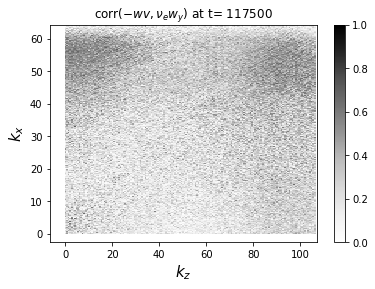

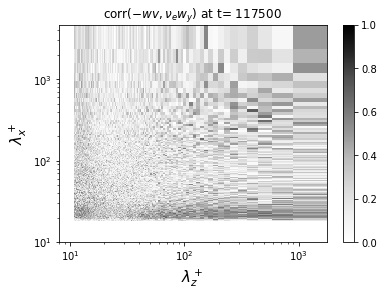

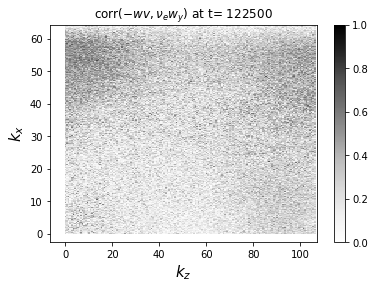

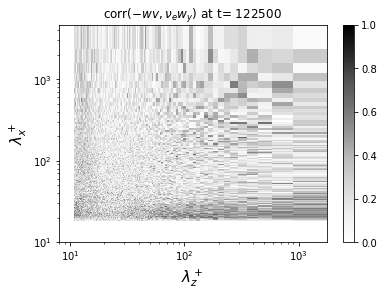

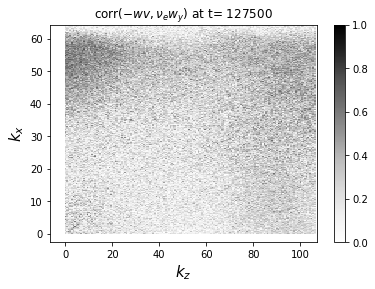

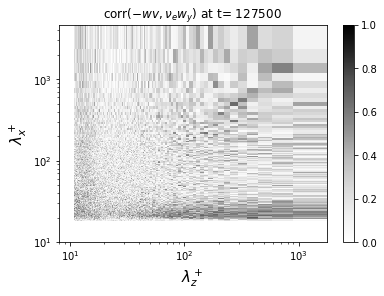

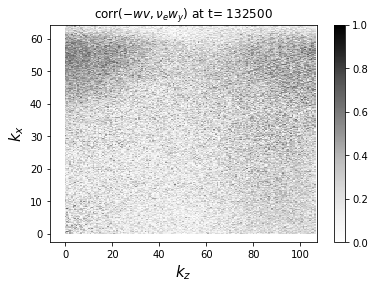

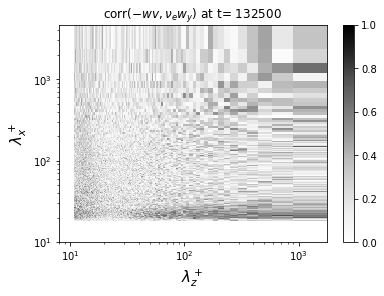

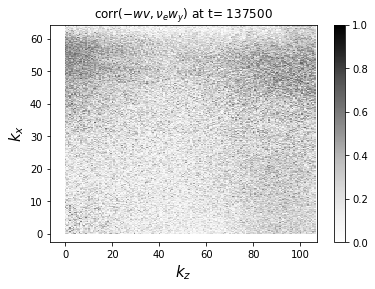

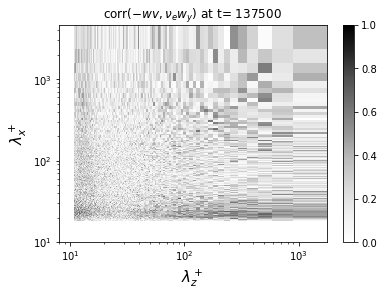

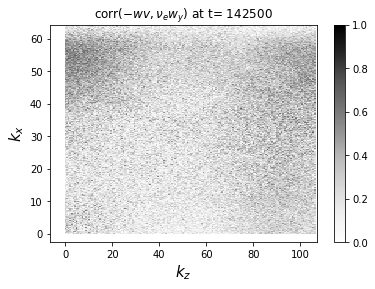

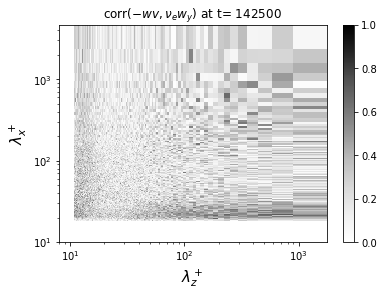

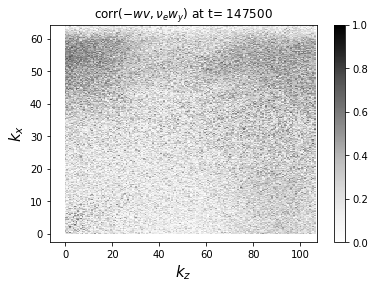

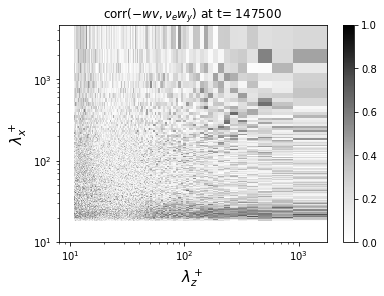

In [11]:
for t in range(102500, 150000,5000):
    plotCorrArr(t)

# Map of eddy viscosity for $u \cdot \nabla u$

%%latex
The diffusion term ($\mathbf{T}_D$), with eddy viscosity enhancement, is (Pujals 2009, POF)
\begin{equation}
    \mathbf{T}_D = \nabla \cdot \big[ \nu_T(y) \big( \nabla \mathbf{u} + (\nabla \mathbf{u}) ^T \big) \big]
\end{equation}

The diffusion term in the $j^{th}$ equation, $\mathbf{T}_D \cdot \mathbf{e}_j$ is
\begin{align}
    \mathbf{T}_D \cdot \mathbf{e}_j  
        &= \partial_{x_k} \big[  \nu_T \big( \partial_{x_k} u^j +  \partial_{x_j} u^k \big) \big] \\
        &= \partial_{x_k} \big( \nu_T  \partial_{x_k} u^j \big) \\
        &= \nu_m \Delta u^j + \nu_e \Delta u^j + \nu'_e \partial_y u^j
\end{align}
where $\Delta = \partial_{xx} + \partial_{yy} + \partial_{zz}$, and $\nu_m$ and $\nu_e$ are molecular and eddy viscosities respectively.


The additional terms due to the introduction of an eddy viscosity are
$$ \mathbf{E} = \nu_e \Delta \mathbf{u} + \nu'_e \partial_y \mathbf{u}, $$
and these are supposed to capture the non-linear term, 
$$ \mathbf{C} = - \big(\mathbf{u} \cdot \nabla \big) \mathbf{u} $$

I'll now compute the Fourier coefficients for $\mathbf{E}$ and $\mathbf{C}$ from DNS data at each snapshot, and calculate the correlation for the two terms as 
$$\mbox{Corr}(j;l,m) = \frac{ \big< \mathbf{E}^j_{l,m}, \mathbf{C}^j_{l,m} \big> } { || \mathbf{E}^j_{l,m} || ||\mathbf{C}^j_{l,m} || } $$
where the inner product is the integral over $y$ of the product of one coefficient with the other's conjugate, and the norm is the square-root of the inner-product.

Because of the way the non-dimensionalization is done and the eddy viscosity is defined in my code, I should be looking at 
$$ \frac{1}{Re}\mathbf{E}$$ 
instead of just $\mathbf{E}$


In [17]:
a0 = 0.25; b0 = 2./3.
Re = 186.
Nx = 512; Nz = 320; N = 192
aArr = a0 * np.arange(Nx//2+1)
bArr = b0 * np.arange(Nz//2+1)
loadPath = physDataDir

yCC = miscUtil.nodesCellCenters(nCells=192)
meanFun = lambda someArr: np.mean(np.mean(someArr, axis=2),axis=1)

# Calculate eddy viscosity and mean velocity profile
meanDict = ops.turbMeanChannel(N=191,Re=Re)
D = pseudo.chebdif(N-1,1)[1].reshape((N-1,N-1))
tmp_nuEddy = meanDict['nu'] - 1.
tmp_dnuEddy = D @ tmp_nuEddy

nuEddy = pseudo.chebint(tmp_nuEddy, 1. - yCC)
dnuEddy = pseudo.chebint(tmp_dnuEddy, 1.-yCC)
U   = pseudo.chebint(meanDict['U'  ], 1.-yCC)
dU  = pseudo.chebint(meanDict['dU' ], 1.-yCC)
d2U = pseudo.chebint(meanDict['d2U'], 1.-yCC)


def getSpecFields(t,ind=0):
    ufName = loadPath+ 'u_it%s.dat'%t
    vfName = loadPath+ 'w_it%s.dat'%t
    wfName = loadPath+ 'v_it%s.dat'%t 
    

    with open(ufName,'rb') as inFile:
        uArrRaw = np.fromfile(inFile, dtype=np.float, count=-1)
    with open(vfName,'rb') as inFile:
        vArrRaw = np.fromfile(inFile, dtype=np.float, count=-1)
    with open(wfName,'rb') as inFile:
        wArrRaw = np.fromfile(inFile, dtype=np.float, count=-1)
    
    uArr = uArrRaw.reshape((1,Nx,Nz,N))
    vArr = vArrRaw.reshape((1,Nx,Nz,N))
    wArr = wArrRaw.reshape((1,Nx,Nz,N))
    velArr = np.concatenate((uArr,vArr,wArr),axis=0)
    velArr = velArr[:,:,:,::-1] 
    # Because original binaries have u,v,w going from 0 to 2, 
    #   I want them going from 1 to -1 (decreasing y)
    
    
    # Convert into fluctuations
    velArr = velArr - meanFun(velArr).reshape((3,1,1,N))
    scalArr = velArr[ind]   # j in u^k d_xk u^j
    
    # Because the binaries are stored for increasing y
    xTerm = (velArr[0] * scalArr).reshape((Nx,Nz,N))
    yTerm = (velArr[1] * scalArr).reshape((Nx,Nz,N))
    zTerm = (velArr[2] * scalArr).reshape((Nx,Nz,N))
    
    # convection term is d_x(xTerm) + d_y(yTerm) + d_z(zTerm)
    #     Or its negative, depending on how you look at it
    # Defining wavenumber arrays to use in differentiation
    lArr = np.arange(Nx//2+1)
    mArr = np.arange(Nz//2+1)
    aArr = a0 * lArr.reshape((lArr.size,1,1))
    bArr = b0 * mArr.reshape((1,mArr.size,1))
    
    # d_x( u u^j)
    dxTermSpec =  (1.j*aArr) * (np.fft.rfft(xTerm, axis=0)/Nx)
    dxTerm = np.fft.irfft(dxTermSpec,axis=0)*Nx
    # To ensure I'm not messing this up, calculate d_x u too
    uxSpec = (1.j*aArr) * (np.fft.rfft(velArr[0], axis=0)/Nx)
    ux = np.fft.irfft(uxSpec,axis=0)*Nx
    
    
    # d_y(v u^j)
    dyTerm = yTerm.copy()
    for ind0 in range(Nx):
        for ind1 in range(Nz):
            dyTerm[ind0,ind1] = miscUtil.cenDiff(yTerm[ind0,ind1],nCells=N)
    # Again, calculate d_y v too        
    vy = velArr[1].copy()
    for ind0 in range(Nx):
        for ind1 in range(Nz):
            vy[ind0,ind1] = miscUtil.cenDiff(velArr[1,ind0,ind1],nCells=N)
    
    # d_z( w u^j)
    dzTermSpec =  (1.j*bArr) * (np.fft.rfft(zTerm, axis=1)/Nz)
    dzTerm = np.fft.irfft(dzTermSpec,axis=1)*Nz
    # Finally, calculate d_z w too
    wzSpec = (1.j*bArr) * (np.fft.rfft(velArr[2], axis=1)/Nz)
    wz = np.fft.irfft(wzSpec,axis=1)*Nz
    
    convTerm = dxTerm + dyTerm + dzTerm
    
    # We also need another term: d_y ( nu_e d_y u^j)
    # I'll compute the term in the next function 
    
    # Compute spectral fields for the convection term and the scalar
    scalSpec  = np.fft.rfftn( scalArr , axes=(0,1))/Nx/Nz
    convSpec = np.fft.rfftn( convTerm, axes=(0,1))/Nx/Nz
    
    return scalSpec, convSpec


def getCorrArr(t,ind=0):
    uSpec, convSpec = getSpecFields(t,ind=ind)
    corrArr = np.zeros((uSpec.shape[0]//2+1, uSpec.shape[1]),dtype=np.complex)
    yCC = miscUtil.nodesCellCenters(nCells=uSpec.shape[-1])
    def diffWall(u):
        """ Derivative at the wall, first order forward/backward difference"""
        # Distance between wall and closest node:
        yStep = yCC[0]  # Coz yCC goes from 0 to 2, and is for cell centers
        
        #u'(+1) = (u(+1) - u(+1-yStep))/yStep
        #u'(-1) = (u(-1+yStep) - u(-1))/yStep
        # u is ordered to go from 1-yStep to -1+yStep ()
        uy_p1 = -u[0]/yStep
        uy_m1 = u[-1]/yStep
        return uy_p1, uy_m1
        
    for l in range(corrArr.shape[0]):
        for m in range(corrArr.shape[1]):
            u_lm  =  uSpec[l,m]
            conv_lm = convSpec[l,m]

            if l==0 and m==0 and ind==0:
                u_lm += U

            # convSpec contains Fourier coeffs for (u^k d_xk) u^j
            
            # I need a derivative of u_lm
            # Let's go with a simple central difference for the derivative
            # This bit is easy. 
            uy_lm = miscUtil.cenDiff(u_lm, nCells= u_lm.size)
            
            # The second derivative is a bit tricky though. 
            # cenDiff() assumes that the function's value is 0 at the walls.
            # This can be fixed by supplying u' at the walls with kwarg 'bvals'
            uyWalls = diffWall(u_lm)
            uy2_lm = miscUtil.cenDiff(uy_lm, nCells= u_lm.size, bvals=uyWalls) 
            # Use uyWalls as the values at the wall

            
            laplacian = (-l**2 * a0**2 - m**2 * b0**2) * u_lm + uy2_lm
            E = nuEddy * laplacian + dnuEddy * uy_lm
            E = E/Re
            
            C = -conv_lm

            corrArr[l,m] = pseudo.chebdot(E,C,N)/ \
                        (pseudo.chebnorm(E,N)*pseudo.chebnorm(C,N))

    return corrArr


def plotCorrArr(t,ind=0,fPrefix='corrEddy',savePath='./'):
    corrArr = getCorrArr(t,ind=ind)
    
    fName = savePath+fPrefix+'_CE%d_wnum_t%d.eps'%(ind,t)
    plt.pcolor(bArr, aArr, np.abs(corrArr), cmap='Greys',vmin=0.,vmax=1.)
    #plt.clim([0.,1.])
    #plt.grid(True)
    ax = plt.gca() 
    plt.xlim([-10*b0,b0*corrArr.shape[1]])
    plt.ylim([-10*a0,a0*corrArr.shape[0]])
    plt.colorbar()
    plt.xlabel("$k_z$",fontsize=15)
    plt.ylabel("$k_x$",fontsize=15)
    plt.title("corr($C,E$) at t=%7.0d"%t)
    plt.savefig(fName,format='eps')
    plt.show()

    fName = savePath+fPrefix+'_CE%d_wlen_t%d.eps'%(ind,t)
    corrArrNew = corrArr[1:,1:]
    lxArr = 2.*np.pi/aArr[1:]
    lzArr = 2.*np.pi/bArr[1:]
    plt.pcolor(Re*lzArr, Re*lxArr, np.abs(corrArrNew), cmap='Greys',vmin=0.,vmax=1.)
    #plt.clim([0.,1.])
    #plt.grid(True)
    plt.xlabel("$\\lambda^+_z$",fontsize=15)
    plt.ylabel("$\\lambda^+_x$",fontsize=15)
    plt.title("corr($C, E$) at t=%7.0d"%t)
    ax = plt.gca() 
    Lx = 2.*np.pi/a0; Lz = 2.*np.pi/b0
    plt.xlim([8, Re*Lz])
    plt.ylim([10, Re*Lx])
    #ax.set_ylim(ax.get_ylim()[::-1]) 
    plt.xscale("log"); plt.yscale("log")
    plt.colorbar()
    plt.savefig(fName,format='eps')
    plt.show()
    return




Using parameters Re=186, alfa=46.5, kapa=0.61, N=191


/home/svadarevu/gitwork/linear/library/miscUtil.py:200: UserWarning: arr supplied to cenDiff must be on y from 1 to -1, NOT -1 to 1
  


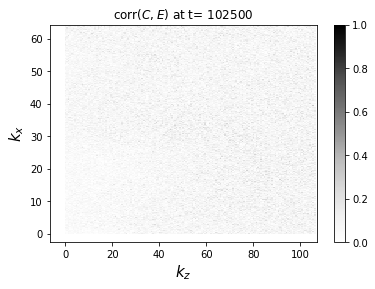

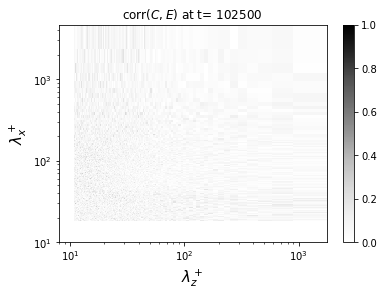

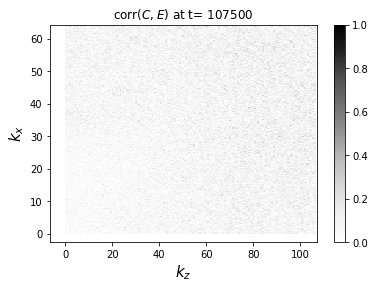

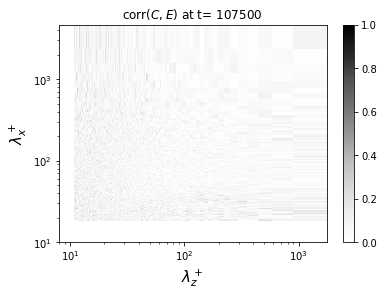

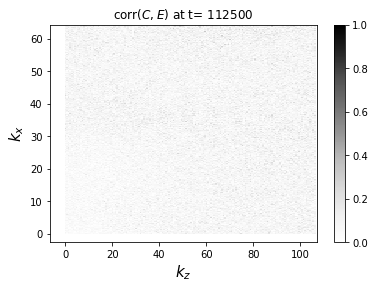

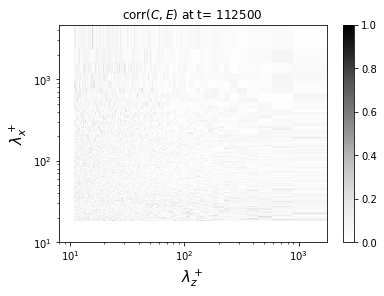

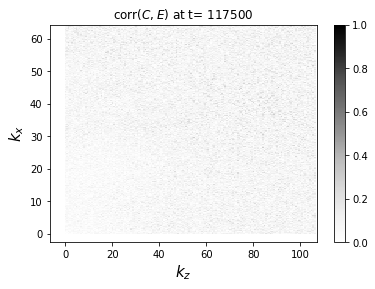

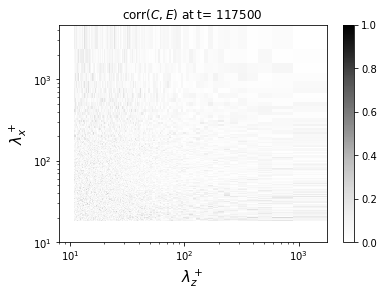

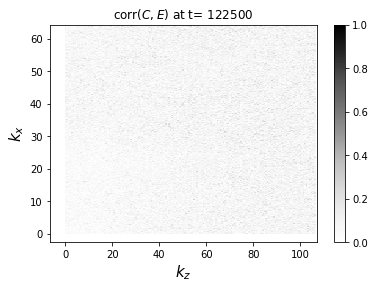

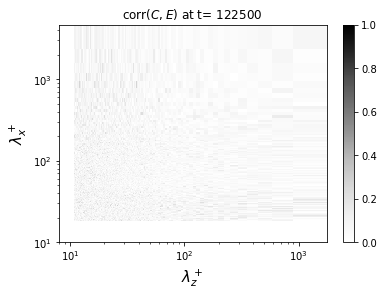

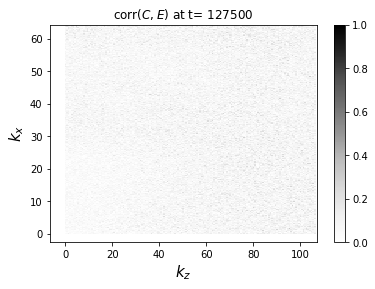

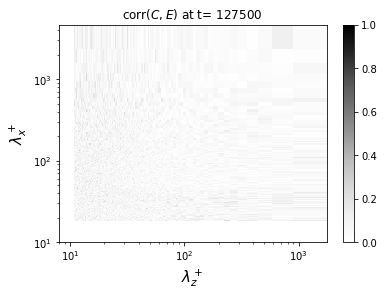

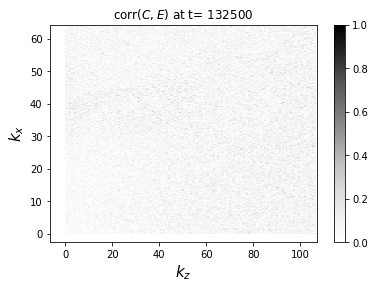

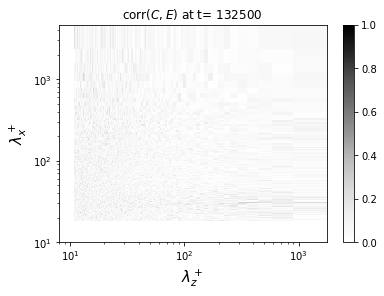

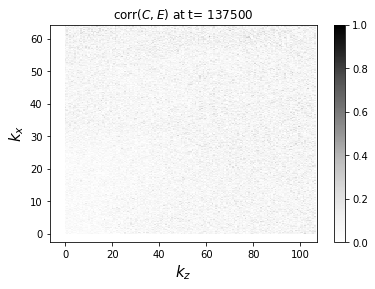

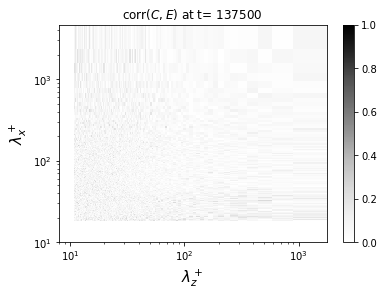

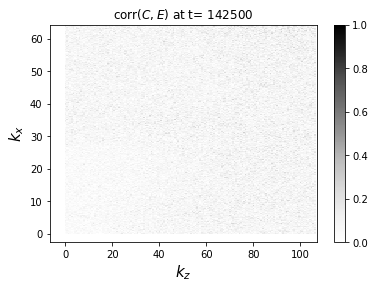

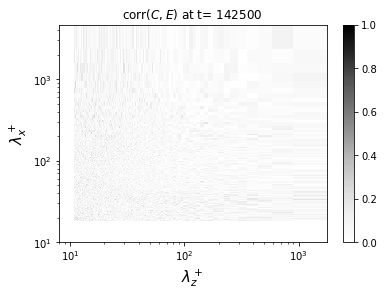

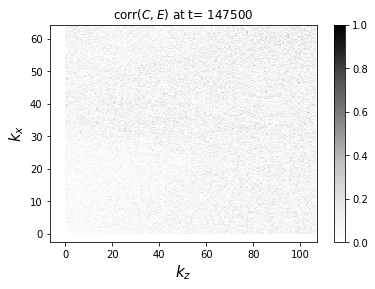

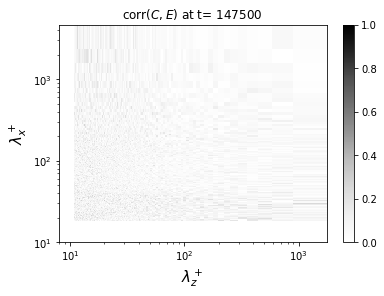

In [18]:
for t in range(102500, 150000,5000):
    plotCorrArr(t)


## Now we project $du^j_{l,m}/dy$  on to the convection terms

### For starters, use l,m = 0,0 and see if the eddy viscosity is properly defined

Using parameters Re=186, alfa=46.5, kapa=0.61, N=192


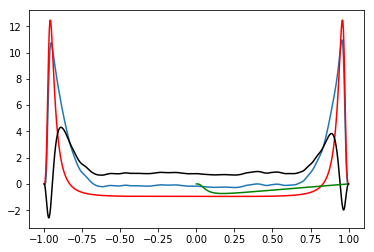

In [72]:
uvFFT = np.fft.rfftn(xConvV, axes=(0,1))/Nx1/Nz1

# Approximate velocity profile and eddy viscosity
meanDict = ops.turbMeanChannel(N=192,Re=186.,alfa=46.5,kapa=0.61)
U = meanDict['U']; dU = meanDict['dU']; d2U = meanDict['d2U']
nuT = meanDict['nu']
nuE = nuT - 1.; Re = 186.
y,DM = pseudo.chebdif(N,2)
D = np.ascontiguousarray(DM[:,:,0])
D2 = np.ascontiguousarray(DM[:,:,1])

dnuE = D @ nuE

# RSS for mode 00 from averaged data
#uv00 = -uvFFT[0,0]
uv00 = np.mean(np.mean(xConvV,axis=1),axis=0)

# For good measure, load uv00 from Lee & Moser's ReTau=186 case
dataArr = np.loadtxt(os.environ['DATA']+'LM_Channel_0180_vel_fluc_prof.dat',comments='%')
uvArr = dataArr[:,5]
yArr = dataArr[:,0]


# RSS from eddy viscosity model
uv00E = 1./Re*( nuE * d2U  +  dnuE * dU ) 

plt.plot(y, np.real(uv00 + uv00E))
plt.plot(y, np.real(uv00E),'r')
plt.plot(y, np.real(uv00),'k')
plt.plot(yArr, np.real(uvArr),'g')

plt.show()


In [16]:
uv00E[:10], uv00[:10]

(array([  9.35334598e-05,   3.02146013e-05,   1.46952615e-03,
          7.56857045e-03,   2.89193131e-02,   8.45492467e-02,
          2.09194453e-01,   4.54272226e-01,   8.92621301e-01,
          1.61166928e+00]),
 array([-1154867.16153654+0.j,  -439794.80427334+0.j,   -42283.66141827+0.j,
          -45586.05176502+0.j,   -28106.05429273+0.j,   -10939.61507916+0.j,
           -7838.17652248+0.j,    -4027.13795353+0.j,    -2340.34810445+0.j,
           -1463.80378947+0.j]))

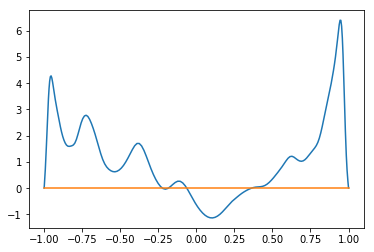

In [70]:
yCC = miscUtil.nodesCellCenters(nCells=192)
plt.plot(yCC, u[10,0])
plt.plot(yCC, np.mean(np.mean(u,axis=1),axis=0))
#plt.ylim([-1.,1.])
plt.show()

In [55]:
uNew.shape, ufft.shape

((128, 80, 192), (128, 41, 192))

# Testing miscUtil.cenDiff()

/home/svadarevu/gitwork/linear/library/miscUtil.py:195: UserWarning: arr supplied to cenDiff must be on y from 1 to -1, NOT -1 to 1
  warn("arr supplied to cenDiff must be on y from 1 to -1, NOT -1 to 1")


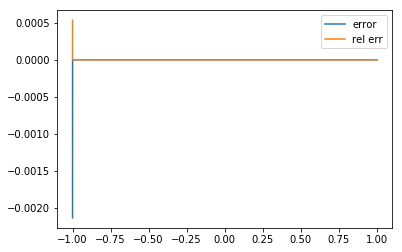

In [49]:
yCC = miscUtil.nodesCellCenters(nCells=192)
yCC1 = 1. - yCC
f = 1. - yCC1**2 
df = -2.*yCC1

df_fun = miscUtil.cenDiff(f, nCells=yCC.size)

plt.plot(yCC, (df - df_fun))
plt.plot(yCC, (df - df_fun)/df)
plt.legend(['error', 'rel err'])
plt.show()

Things seem a bit off at the wall, but that's still small enough to be negligible. 

# Eddy viscosity as an $Re$ offset

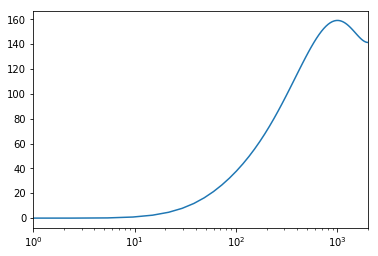

In [12]:
N = 127
kapa = 0.426; alfa = 25.4; Re = 2000.
nuT = lambda zt: -0.5 + 0.5*np.sqrt( 1.+
                (kapa*Re/3.* (2.*zt - zt**2) * (3. - 4.*zt + 2.*zt**2) *
                             (1. - np.exp( (np.abs(zt-1.)-1.)*Re/alfa )   )    )**2)
y,D = pseudo.chebdif(N,1)
D = D[:,:,0]
nuProfile = nuT(1.+y)
plt.plot(Re*(1.-y),nuProfile)
#plt.plot(Re*(1.-y), D@nuProfile)
plt.xlim([1.,Re])
plt.xscale('log')
plt.show()

In [7]:

nuProfile[:5]

array([  1.69088776e-09,   4.29620996e-07,   1.08734054e-05,
         1.06712802e-04,   6.21570208e-04])

# Homogenizing velocity with eddy viscosity

I want to look at amplification about 